Loading FastText model...
Generating embeddings for full dataset...


100%|██████████| 18082/18082 [00:00<00:00, 37888.82it/s]


Before SMOTE: [15505  2577]
After SMOTE: [15505 15505]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training model...
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 01 - Accuracy: 0.8586 | Loss: 0.3402 | F1: 0.8513
✅ Saved new best model
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 02 - Accuracy: 0.8425 | Loss: 0.3871 | F1: 0.8275
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 03 - Accuracy: 0.8947 | Loss: 0.2547 | F1: 0.9011
✅ Saved new best model
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 04 - Accuracy: 0.8850 | Loss: 0.2833 | F1: 0.8788
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 05 - Accuracy: 0.9147 | Loss: 0.2205 | F1: 0.9188
✅ Saved new best model
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 06 - Accuracy: 0.9250 | Loss: 0.1954 | F1: 0.9268
✅ Saved new best model
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 07 - Accuracy: 0.9152 | Loss: 0.2101 | F1: 0.9195
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 08 - Accuracy: 0.9229 | Loss: 0.2014 | F1: 0.9241
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 09 - Accuracy: 0.9276 | Loss: 0.1931 | F1: 0.9294
✅ Saved new best 

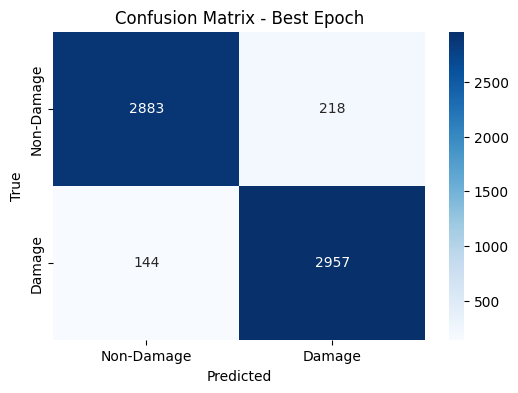

Converting best model to TFLite...
Saved artifact at '/tmp/tmp1du7yf17'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 300), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  138114674171856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138114674170128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138114674171664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138114674170704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138114674172048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138114674168784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138114674168976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138114674170512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138117478473104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138117478475600: TensorSpec(shape=(), dtype=tf.resource,

W0000 00:00:1747741575.851242      91 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1747741575.851269      91 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.


In [2]:
# ========== Imports ==========
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import gensim.downloader as api
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf

# ========== Load Dataset ==========
file_path = "/kaggle/input/mergefile/Merged_Disasters(2).csv"
df = pd.read_csv(file_path)

# ========== Preprocess Labels ==========
label_map = {'damage': 1, 'non-damage': 0}
df['Binary_class'] = df['Binary_class'].str.strip().str.lower().map(label_map)
df['Processed_data'] = df['Processed_data'].fillna("")

# ========== Load FastText Model ==========
print("Loading FastText model...")
fasttext_model = api.load("fasttext-wiki-news-subwords-300")
embedding_dim = 300

# ========== Create Document Embeddings ==========
def get_avg_embedding(text, model, dim):
    words = text.split()
    embeddings = [model[word] for word in words if word in model]
    return np.mean(embeddings, axis=0) if embeddings else np.zeros(dim)

print("Generating embeddings for full dataset...")
X_full = np.vstack([get_avg_embedding(text, fasttext_model, embedding_dim) for text in tqdm(df['Processed_data'])])
y_full = df['Binary_class'].values

# ========== Apply SMOTE ==========
print("Before SMOTE:", np.bincount(y_full))
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_full, y_full)
print("After SMOTE:", np.bincount(y_resampled))

# ========== Split Data ==========
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.20, stratify=y_resampled, random_state=42)

# ========== Callback to Save Best Model Based on F1-Score ==========
class SaveBestModel(Callback):
    def __init__(self, X_test, y_test):
        super().__init__()
        self.X_test = X_test
        self.y_test = y_test
        self.best_f1 = 0
        self.best_epoch = 0
        self.best_acc = 0
        self.best_loss = 0

    def on_epoch_end(self, epoch, logs=None):
        y_pred = (self.model.predict(self.X_test) > 0.5).astype(int)
        f1 = f1_score(self.y_test, y_pred)
        loss, acc = self.model.evaluate(self.X_test, self.y_test, verbose=0)

        print(f"Epoch {epoch+1:02d} - Accuracy: {acc:.4f} | Loss: {loss:.4f} | F1: {f1:.4f}")
        if f1 > self.best_f1:
            self.best_f1 = f1
            self.best_acc = acc
            self.best_loss = loss
            self.best_epoch = epoch + 1
            self.model.save("best_model.h5")  # Save best model
            print("✅ Saved new best model")

# ========== Build Model ==========
model = Sequential([
    Dense(256, activation='relu', input_shape=(embedding_dim,)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

# ========== Train Model ==========
print("Training model...")
metrics_callback = SaveBestModel(X_test, y_test)
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    verbose=0,
    validation_data=(X_test, y_test),
    callbacks=[metrics_callback]
)

# ========== Load Best Model ==========
best_model = load_model("best_model.h5")
y_pred = (best_model.predict(X_test) > 0.5).astype(int)
y_prob = best_model.predict(X_test)
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=0)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

# ========== Print Final Best Metrics ==========
print(f"\n✅ Best Epoch: {metrics_callback.best_epoch}")
print(f"✅ Best Accuracy: {metrics_callback.best_acc:.4f}")
print(f"✅ Best Loss: {metrics_callback.best_loss:.4f}")
print(f"✅ Best F1-Score: {metrics_callback.best_f1:.4f}")

print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Damage', 'Damage']))

# ========== Confusion Matrix ==========
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Damage', 'Damage'], yticklabels=['Non-Damage', 'Damage'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Best Epoch")
plt.show()

# ========== Convert to TFLite ==========
print("Converting best model to TFLite...")
converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
tflite_model = converter.convert()

# Save TFLite Model
with open("best_model.tflite", "wb") as f:
    f.write(tflite_model)
print("✅ TFLite model saved as 'best_model.tflite'")
